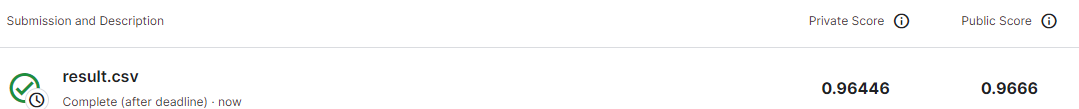

In [8]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


### 이미지 전처리

In [9]:
IMAGE_SIZE = (300, 300)

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
#SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)

    # 이미지를 224, 224로 줄이기
    image = cv2.resize(image, IMAGE_SIZE)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

images = train_data["image_id"].apply(load_image)


In [10]:
images = np.stack(images)
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [11]:
BATCH_SIZE = 4
LEARNING_RATE = 0.00025
K_NUM= 4

from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
efmodel = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape= (IMAGE_SIZE[1], IMAGE_SIZE[0], 3))
model = Sequential()
model.add(efmodel)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 16, 16, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 12,936,770
Trainable params: 12,827,554
Non-trainable params: 109,216
_________________________________________________________________


In [13]:
y_categorical = np.argmax(labels, axis=1)
k = 5  # Number of folds
stratified_kfold = StratifiedKFold(n_splits=k)

history = None
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
    if i != K_NUM:
        continue
        
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=[0.9, 1.1],
                                   brightness_range= [0.8, 1],
                                   fill_mode='nearest'
                                   )

    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE)
    
    modelpath = f'./model/train13/kfold{i}/'
    modelname = 'best.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath+modelname, monitor='val_loss', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    history = model.fit(train_generator, epochs=80, verbose=1, callbacks=[checkpointer, reduce_lr], validation_data=val_generator)

Epoch 1/80
365/365 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.7968
Epoch 1: val_loss improved from inf to 0.22124, saving model to ./model/train13/kfold4\best.hdf5
365/365 [==============================] - 75s 176ms/step - loss: 0.5991 - accuracy: 0.7968 - val_loss: 0.2212 - val_accuracy: 0.9286 - lr: 2.5000e-04
Epoch 2/80
 26/365 [=>............................] - ETA: 47s - loss: 0.3940 - accuracy: 0.8942

KeyboardInterrupt: 